<a href="https://colab.research.google.com/github/r-bitbot/Malnutrition-Detection/blob/main/malnutrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
import keras_hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential, layers
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = '/content/drive/My Drive/'
img_size = (224, 224)
batch_size = 16

In [6]:
datagen_vgg = ImageDataGenerator(
    preprocessing_function=vgg_preprocess_input,
    validation_split=0.2,
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.7,1.3],
    horizontal_flip=True,
    vertical_flip=True
)

datagen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess_input,
    validation_split=0.2,
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.7,1.3],
    horizontal_flip=True,
    vertical_flip=True
)

In [7]:
train_gen_16 = datagen_vgg.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='training'
)

val_gen_16 = datagen_vgg.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='validation'
)

Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


In [8]:
base_model_16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_16.trainable = False

x = base_model_16.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_16 = Model(inputs=base_model_16.input, outputs=outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model_16.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [10]:
counter_16 = Counter(train_gen_16.classes)
total_16 = sum(counter_16.values())
class_weight_16 = {i: total_16/(2*count) for i, count in counter_16.items()}
print("Class weights:", class_weight_16)

Class weights: {np.int32(0): 0.6792452830188679, np.int32(1): 1.894736842105263}


In [11]:
callbacks_16 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg16_model.h5', save_best_only=True)
]

history_16 = model_16.fit(
    train_gen_16,
    epochs=20,
    validation_data=val_gen_16,
    class_weight=class_weight_16,
    callbacks=callbacks_16
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5419 - loss: 0.7477

14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5422 - loss: 0.7459 - val_accuracy: 0.6038 - val_loss: 0.6802
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5434 - loss: 0.7559

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.5445 - loss: 0.7549 - val_accuracy: 0.6981 - val_loss: 0.6562
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.5856 - loss: 0.6634

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 447ms/step - accuracy: 0.5851 - loss: 0.6661 - val_accuracy: 0.7736 - val_loss: 0.6332
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.6514 - loss: 0.6647 - val_accuracy: 0.6226 - val_loss: 0.6648
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.6242 - loss: 0.6614 - val_accuracy: 0.7358 - val_loss: 0.6464
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.5142 - loss: 0.7072

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - accuracy: 0.5182 - loss: 0.7053 - val_accuracy: 0.7925 - val_loss: 0.6045
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6559 - loss: 0.5951

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.6560 - loss: 0.5976 - val_accuracy: 0.7925 - val_loss: 0.5875
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7286 - loss: 0.6018

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 446ms/step - accuracy: 0.7260 - loss: 0.6044 - val_accuracy: 0.8491 - val_loss: 0.5853
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6175 - loss: 0.6193

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.6183 - loss: 0.6207 - val_accuracy: 0.8302 - val_loss: 0.5603
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6822 - loss: 0.6320

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 390ms/step - accuracy: 0.6843 - loss: 0.6298 - val_accuracy: 0.8679 - val_loss: 0.5570
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7424 - loss: 0.5862

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step - accuracy: 0.7426 - loss: 0.5852 - val_accuracy: 0.8491 - val_loss: 0.5396
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7873 - loss: 0.5136

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.7863 - loss: 0.5168 - val_accuracy: 0.8491 - val_loss: 0.5198
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.8038 - loss: 0.5532 - val_accuracy: 0.8868 - val_loss: 0.5329
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.6744 - loss: 0.6017 - val_accuracy: 0.8491 - val_loss: 0.5375
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8350 - loss: 0.5048

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - accuracy: 0.8334 - loss: 0.5045 - val_accuracy: 0.8491 - val_loss: 0.5001
Epoch 16/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7888 - loss: 0.5434

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step - accuracy: 0.7865 - loss: 0.5440 - val_accuracy: 0.8868 - val_loss: 0.4835
Epoch 17/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7994 - loss: 0.4857

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.7995 - loss: 0.4882 - val_accuracy: 0.8868 - val_loss: 0.4609
Epoch 18/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step - accuracy: 0.7961 - loss: 0.5499 - val_accuracy: 0.8679 - val_loss: 0.5029
Epoch 19/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.8409 - loss: 0.4895 - val_accuracy: 0.8302 - val_loss: 0.4849
Epoch 20/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7862 - loss: 0.4906

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - accuracy: 0.7854 - loss: 0.4918 - val_accuracy: 0.9245 - val_loss: 0.4478


In [12]:
def predict_image(img_path, model, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model_16.predict(img_array)[0][0]
    return "Healthy" if pred > 0.5 else "Malnourished"

print(predict_image('/content/drive/My Drive/malnourished/malnourished_471.jpg', model_16))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Healthy


In [13]:
train_gen_19 = datagen_vgg.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='training'
)

val_gen_19 = datagen_vgg.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='validation'
)

Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


In [14]:
base_model_19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_19.trainable = False

y = base_model_19.output
y = GlobalAveragePooling2D()(y)
y = Dense(256, activation='relu')(y)
y = Dropout(0.5)(y)
outputs = Dense(1, activation='sigmoid')(y)

model_19 = Model(inputs=base_model_19.input, outputs=outputs)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
model_19.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
counter_19 = Counter(train_gen_19.classes)
total_19 = sum(counter_19.values())
class_weight_19 = {i: total_19/(2*count) for i, count in counter_19.items()}
print("Class weights:", class_weight_19)

Class weights: {np.int32(0): 0.6792452830188679, np.int32(1): 1.894736842105263}


In [17]:
callbacks_19 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg19_model.h5', save_best_only=True)
]

history_19 = model_19.fit(
    train_gen_19,
    epochs=20,
    validation_data=val_gen_19,
    class_weight=class_weight_19,
    callbacks=callbacks_19
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.5362 - loss: 0.8169

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 613ms/step - accuracy: 0.5381 - loss: 0.8135 - val_accuracy: 0.7358 - val_loss: 0.6648
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - accuracy: 0.5147 - loss: 0.7671 - val_accuracy: 0.6226 - val_loss: 0.6803
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.5242 - loss: 0.6953 - val_accuracy: 0.6792 - val_loss: 0.6714
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5332 - loss: 0.7193

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - accuracy: 0.5322 - loss: 0.7182 - val_accuracy: 0.7358 - val_loss: 0.6529
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5387 - loss: 0.7326

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 381ms/step - accuracy: 0.5380 - loss: 0.7318 - val_accuracy: 0.7925 - val_loss: 0.6261
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5984 - loss: 0.7599

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - accuracy: 0.5986 - loss: 0.7558 - val_accuracy: 0.7736 - val_loss: 0.6087
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6499 - loss: 0.5931

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6470 - loss: 0.5984 - val_accuracy: 0.7925 - val_loss: 0.5666
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.6775 - loss: 0.6317 - val_accuracy: 0.8679 - val_loss: 0.5935
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 413ms/step - accuracy: 0.6126 - loss: 0.5902 - val_accuracy: 0.8679 - val_loss: 0.5735
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.6743 - loss: 0.6470 - val_accuracy: 0.8302 - val_loss: 0.5754
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.6887 - loss: 0.5829 - val_accuracy: 0.8113 - val_loss: 0.5841
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - accuracy: 0.6798 - loss: 0.6129 - val_accuracy: 0.7925 - val_loss: 0.5730


In [18]:
def predict_image(img_path, model, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model_19.predict(img_array)[0][0]
    return "Healthy" if pred > 0.5 else "Malnourished"


print(predict_image('/content/drive/My Drive/malnourished/malnourished_473.jpg', model_19))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Healthy


In [19]:
train_gen_res = datagen_resnet.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='training'
)

val_gen_res = datagen_resnet.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='validation'
)

Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


In [20]:
model_res = keras_hub.models.ResNetBackbone.from_preset("resnet_18_imagenet")

In [21]:
model_res = Sequential([
    model_res,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(1, activation='sigmoid')
])

In [22]:
model_res.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
counter_res = Counter(train_gen_res.classes)
total_res = sum(counter_res.values())
class_weight_res = {i: total_res/(2*count) for i, count in counter_res.items()}
print("Class weights:", class_weight_res)

Class weights: {np.int32(0): 0.6792452830188679, np.int32(1): 1.894736842105263}


In [24]:
callbacks_res = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet_model.h5', save_best_only=True)
]

history_res = model_res.fit(
    train_gen_res,
    epochs=20,
    validation_data=val_gen_res,
    class_weight=class_weight_res,
    callbacks=callbacks_res
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4712 - loss: 0.7420

14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4737 - loss: 0.7402 - val_accuracy: 0.6792 - val_loss: 0.6473
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7005 - loss: 0.6284

14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.6998 - loss: 0.6278 - val_accuracy: 0.7736 - val_loss: 0.5750
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7090 - loss: 0.6063

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step - accuracy: 0.7096 - loss: 0.6075 - val_accuracy: 0.8302 - val_loss: 0.5222
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.7731 - loss: 0.5587 - val_accuracy: 0.8868 - val_loss: 0.5332
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.7494 - loss: 0.5839

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.7485 - loss: 0.5821 - val_accuracy: 0.9245 - val_loss: 0.4675
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8329 - loss: 0.4408

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.8345 - loss: 0.4411 - val_accuracy: 0.9057 - val_loss: 0.4255
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8338 - loss: 0.4748

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.8350 - loss: 0.4718 - val_accuracy: 0.9057 - val_loss: 0.3756
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8760 - loss: 0.3561

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.8759 - loss: 0.3569 - val_accuracy: 0.9057 - val_loss: 0.3020
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9211 - loss: 0.3115

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 491ms/step - accuracy: 0.9202 - loss: 0.3124 - val_accuracy: 0.9057 - val_loss: 0.2840
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9327 - loss: 0.2659

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.9316 - loss: 0.2672 - val_accuracy: 0.9623 - val_loss: 0.2758
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9440 - loss: 0.2713

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 437ms/step - accuracy: 0.9428 - loss: 0.2703 - val_accuracy: 0.9245 - val_loss: 0.2448
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.9349 - loss: 0.2219 - val_accuracy: 0.9434 - val_loss: 0.2574
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.9334 - loss: 0.1933 - val_accuracy: 0.9434 - val_loss: 0.2504
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9514 - loss: 0.1675

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.9516 - loss: 0.1672 - val_accuracy: 0.9057 - val_loss: 0.2119
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9267 - loss: 0.1851

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - accuracy: 0.9279 - loss: 0.1829 - val_accuracy: 0.9623 - val_loss: 0.1692
Epoch 16/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.9799 - loss: 0.1162 - val_accuracy: 0.9245 - val_loss: 0.1844
Epoch 17/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9760 - loss: 0.1017

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 383ms/step - accuracy: 0.9758 - loss: 0.1021 - val_accuracy: 0.9434 - val_loss: 0.1636
Epoch 18/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.9767 - loss: 0.1061 - val_accuracy: 0.9245 - val_loss: 0.2109
Epoch 19/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.9711 - loss: 0.0992 - val_accuracy: 0.9623 - val_loss: 0.1881
Epoch 20/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9484 - loss: 0.1608

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 524ms/step - accuracy: 0.9479 - loss: 0.1605 - val_accuracy: 0.9811 - val_loss: 0.1634


In [25]:
def predict_image(img_path, model, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    return "Healthy" if pred > 0.5 else "Malnourished"

print(predict_image('/content/drive/My Drive/malnourished/malnourished_473.jpg', model_res))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Healthy


In [26]:
from sklearn.metrics import accuracy_score, precision_score, classification_report

def get_preds_labels(generator, model):
    preds = []
    labels = []
    for i in range(len(generator)):
        x, y_true = generator[i]
        y_pred = model.predict(x)
        preds.extend(y_pred.flatten())
        labels.extend(y_true)
    preds = np.array(preds) > 0.5
    labels = np.array(labels).astype(bool)
    return labels, preds

In [27]:
labels_16, preds_16 = get_preds_labels(val_gen_16, model_16)
accuracy_16 = accuracy_score(labels_16, preds_16)
precision_16 = precision_score(labels_16, preds_16)
report_16 = classification_report(labels_16, preds_16, target_names=['Malnourished', 'Healthy'])

print("VGG16 Accuracy:", accuracy_16)
print("VGG16 Precision:", precision_16)
print(report_16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
VGG16 Accuracy: 0.8679245283018868
VGG16 Precision: 1.0
              precision    recall  f1-score   support

Malnourished       0.85      1.00      0.92        39
     Healthy       1.00      0.50      0.67        14

    accuracy                           0.87        53
   macro avg       0.92      0.75      0.79        53
weighted avg       0.89      0.87      0.85        53



In [28]:
labels_19, preds_19 = get_preds_labels(val_gen_19, model_19)
accuracy_19 = accuracy_score(labels_19, preds_19)
precision_19 = precision_score(labels_19, preds_19)
report_19 = classification_report(labels_19, preds_19, target_names=['Malnourished', 'Healthy'])

print("\nVGG19 Accuracy:", accuracy_19)
print("VGG19 Precision:", precision_19)
print(report_19)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step

VGG19 Accuracy: 0.8490566037735849
VGG19 Precision: 1.0
              precision    recall  f1-score   support

Malnourished       0.83      1.00      0.91        39
     Healthy       1.00      0.43      0.60        14

    accuracy                           0.85        53
   macro avg       0.91      0.71      0.75        53
weighted avg       0.87      0.85      0.83        53



In [29]:
labels_res, preds_res = get_preds_labels(val_gen_res, model_res)
accuracy_res = accuracy_score(labels_res, preds_res)
precision_res = precision_score(labels_res, preds_res)
report_res = classification_report(labels_res, preds_res, target_names=['Malnourished', 'Healthy'])

print("\nResNet50 Accuracy:", accuracy_res)
print("ResNet50 Precision:", precision_res)
print(report_res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

ResNet50 Accuracy: 0.9245283018867925
ResNet50 Precision: 0.8125
              precision    recall  f1-score   support

Malnourished       0.97      0.92      0.95        39
     Healthy       0.81      0.93      0.87        14

    accuracy                           0.92        53
   macro avg       0.89      0.93      0.91        53
weighted avg       0.93      0.92      0.93        53



In [30]:
import matplotlib.pyplot as plt
import numpy as np

models = ['VGG16', 'VGG19', 'ResNet50']
accuracy = [0.8868, 0.8868, 0.9434]
precision = [1.0, 1.0, 1.0]
recall_malnourished = [1.0, 1.0, 1.0]
recall_healthy = [0.57, 0.57, 0.79]
f1_malnourished = [0.93, 0.93, 0.96]
f1_healthy = [0.73, 0.73, 0.88]

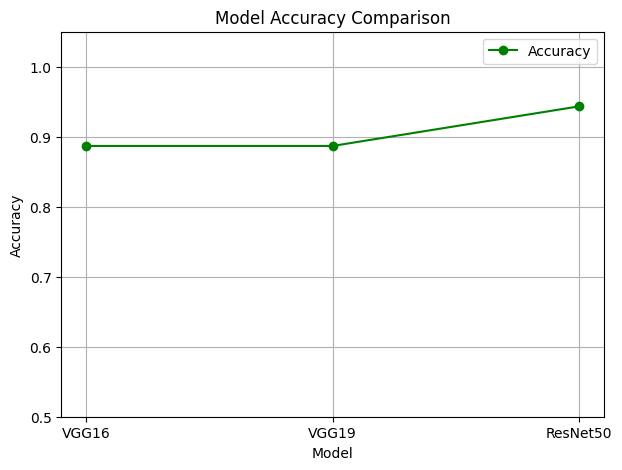

In [31]:
plt.figure(figsize=(7,5))
plt.plot(models, accuracy, marker='o', color='green', label='Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0.5, 1.05)
plt.grid(True)
plt.legend()
plt.show()

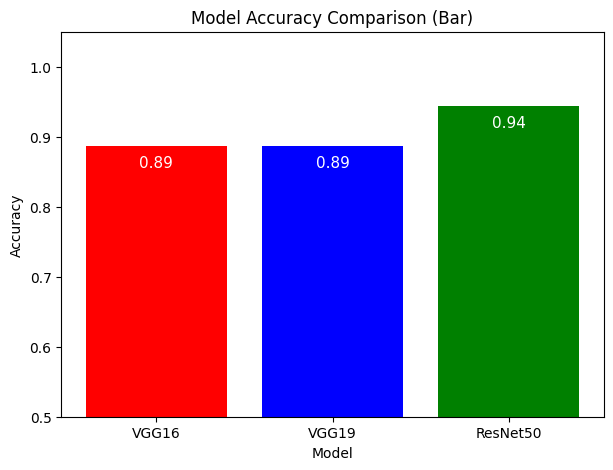

In [32]:
plt.figure(figsize=(7,5))
bars = plt.bar(models, accuracy, color=['red', 'blue', 'green'])
plt.title('Model Accuracy Comparison (Bar)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0.5, 1.05)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.03, f'{bar.get_height():.2f}', ha='center', color='white', fontsize=11)
plt.show()

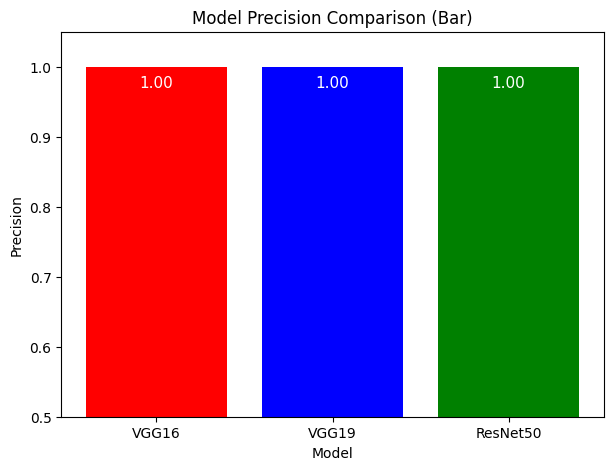

In [33]:
plt.figure(figsize=(7,5))
bars = plt.bar(models, precision, color=['red', 'blue', 'green'])
plt.title('Model Precision Comparison (Bar)')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.ylim(0.5, 1.05)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.03, f'{bar.get_height():.2f}', ha='center', color='white', fontsize=11)
plt.show()

In [34]:
labels = ['Malnourished', 'Healthy']
x = np.arange(len(models))
width = 0.25

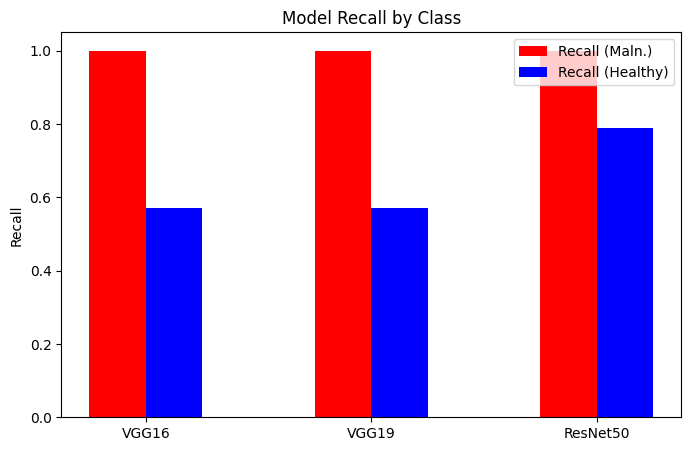

In [35]:
plt.figure(figsize=(8,5))
plt.bar(x - width/2, recall_malnourished, width, label='Recall (Maln.)', color='red')
plt.bar(x + width/2, recall_healthy, width, label='Recall (Healthy)', color='blue')
plt.xticks(x, models)
plt.ylabel('Recall')
plt.title('Model Recall by Class')
plt.ylim(0, 1.05)
plt.legend()
plt.show()

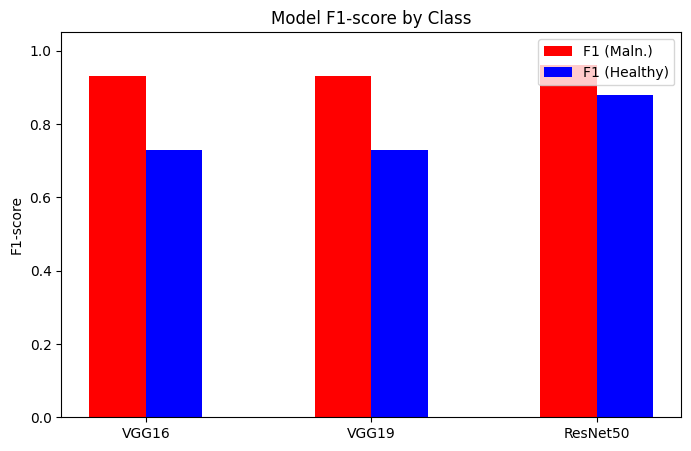

In [36]:
plt.figure(figsize=(8,5))
plt.bar(x - width/2, f1_malnourished, width, label='F1 (Maln.)', color='red')
plt.bar(x + width/2, f1_healthy, width, label='F1 (Healthy)', color='blue')
plt.xticks(x, models)
plt.ylabel('F1-score')
plt.title('Model F1-score by Class')
plt.ylim(0, 1.05)
plt.legend()
plt.show()